# 07 - Predicción de Ventas con Datos Semanales (Olist)

## Objetivos

1. **Data Wrangling**: Agregar datos semanalmente para obtener ~100 puntos vs ~20 mensuales
2. **Feature Engineering**: Crear lags, medias móviles y features de calendario
3. **Correlación Cruzada**: Analizar si el sentimiento en semana $t$ impacta ventas en $t+1$ y $t+2$
4. **Modelado Robusto**: Entrenar Ridge y RandomForest con separación temporal estricta
5. **Exportación**: Guardar modelo y datos recientes para que el agente haga predicciones

## Datasets

- `olist_orders.parquet` - Ordenes con precios y fechas
- `olist_reviews.parquet` - Reviews con scores y texto

## Cambios vs Versión Anterior

- **Granularidad**: Semanal ('W') en lugar de Mensual ('M') - ~100 puntos vs ~20
- **Sin filtro MIN_REVENUE**: Mantenemos todas las semanas, rellenamos vacíos con 0
- **Reindex completo**: date_range + ffill para reviews
- **Features mejoradas**: lags semanales, week_of_year para estacionalidad

In [59]:
# Imports
import sys
from pathlib import Path
import json

# Agregar src al path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ML
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Settings
from tfm.config.settings import get_settings
settings = get_settings()

print(f"Project root: {project_root}")
print(f"Silver dir: {settings.silver_dir}")

Project root: c:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents
Silver dir: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\data\silver


## 1. Carga de Datos

In [60]:
# Cargar datos de silver
orders_path = settings.silver_dir / "olist_orders.parquet"
reviews_path = settings.silver_dir / "olist_reviews.parquet"

print(f"Orders existe: {orders_path.exists()}")
print(f"Reviews existe: {reviews_path.exists()}")

if not orders_path.exists() or not reviews_path.exists():
    print("Ejecuta primero: uv run python scripts/build_silver.py --dataset olist")
else:
    orders_df = pl.read_parquet(orders_path)
    reviews_df = pl.read_parquet(reviews_path)
    
    print(f"\nOrders: {orders_df.height:,} filas, {orders_df.width} columnas")
    print(f"Reviews: {reviews_df.height:,} filas, {reviews_df.width} columnas")

Orders existe: True
Reviews existe: True

Orders: 99,441 filas, 10 columnas
Reviews: 99,224 filas, 11 columnas


In [61]:
# Explorar estructura de datos
print("Columnas de Orders:")
print(orders_df.columns)
print("\nColumnas de Reviews:")
print(reviews_df.columns)

Columnas de Orders:
['order_id', 'customer_id', 'order_status', 'purchase_date', 'year', 'month', 'day_of_week', 'order_total', 'freight_total', 'item_count']

Columnas de Reviews:
['review_id', 'order_id', 'review_score', 'text', 'text_length', 'word_count', 'has_comment', 'is_ambiguous', 'language', 'review_creation_date', 'review_answer_timestamp']


In [62]:
# Ver rango de fechas
print("Rango de fechas en Orders:")
print(f"  Min: {orders_df['purchase_date'].min()}")
print(f"  Max: {orders_df['purchase_date'].max()}")

Rango de fechas en Orders:
  Min: 2016-09-04 21:15:19
  Max: 2018-10-17 17:30:18


## 2. Data Wrangling - Agregación Semanal


In [63]:
# Convertir a pandas y crear columna de fecha datetime
orders_pd = orders_df.to_pandas()
orders_pd['purchase_date'] = pd.to_datetime(orders_pd['purchase_date'])

# Agregar ventas por semana (resample W = semana, cierra el domingo)
orders_pd.set_index('purchase_date', inplace=True)

sales_weekly = orders_pd.resample('W').agg({
    'order_id': 'count',
    'order_total': 'sum',
    'item_count': 'sum'
}).reset_index()

sales_weekly.columns = ['week', 'order_count', 'total_revenue', 'total_items']

print(f"Semanas con datos de ventas: {len(sales_weekly)}")
print(f"\nRango: {sales_weekly['week'].min()} a {sales_weekly['week'].max()}")
sales_weekly.head(10)

Semanas con datos de ventas: 112

Rango: 2016-09-04 00:00:00 a 2018-10-21 00:00:00


,week,order_count,total_revenue,total_items
0,2016-09-04,1,72.89,2.0
1,2016-09-11,1,59.50,1.0
2,2016-09-18,2,134.97,3.0
3,2016-09-25,0,0.00,0.0
4,2016-10-02,1,100.00,1.0
5,2016-10-09,283,45715.09,322.0
6,2016-10-16,39,3692.57,40.0
7,2016-10-23,1,0.00,0.0
8,2016-10-30,0,0.00,0.0
9,2016-11-06,0,0.00,0.0


In [64]:
# Agregar reviews por semana
reviews_pd = reviews_df.to_pandas()
reviews_pd['review_date'] = pd.to_datetime(reviews_pd['review_answer_timestamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Eliminar reviews sin fecha
reviews_pd = reviews_pd.dropna(subset=['review_date'])
reviews_pd.set_index('review_date', inplace=True)

reviews_weekly = reviews_pd.resample('W').agg({
    'review_id': 'count',
    'review_score': ['mean', 'std']
}).reset_index()

# Flatten column names
reviews_weekly.columns = ['week', 'review_count', 'avg_review_score', 'std_review_score']

print(f"Semanas con datos de reviews: {len(reviews_weekly)}")
reviews_weekly.head(10)

Semanas con datos de reviews: 109


,week,review_count,avg_review_score,std_review_score
0,2016-10-09,1,1.000000,NaN
1,2016-10-16,3,3.333333,2.081666
2,2016-10-23,52,4.538462,0.959198
3,2016-10-30,77,4.025974,1.450717
4,2016-11-06,59,3.627119,1.596314
5,2016-11-13,26,3.769231,1.582598
6,2016-11-20,18,2.277778,1.742397
7,2016-11-27,13,3.153846,1.863963
8,2016-12-04,21,2.285714,1.585650
9,2016-12-11,23,2.739130,1.912100


In [65]:
# Crear rango de fechas completo (todas las semanas)
min_date = min(sales_weekly['week'].min(), reviews_weekly['week'].min())
max_date = max(sales_weekly['week'].max(), reviews_weekly['week'].max())

full_weeks = pd.date_range(start=min_date, end=max_date, freq='W')
print(f"Rango completo: {len(full_weeks)} semanas")
print(f"  Desde: {full_weeks.min()}")
print(f"  Hasta: {full_weeks.max()}")

Rango completo: 114 semanas
  Desde: 2016-09-04 00:00:00
  Hasta: 2018-11-04 00:00:00


In [66]:
# Reindex sales: semanas sin ventas = 0
sales_weekly = sales_weekly.set_index('week').reindex(full_weeks).reset_index()
sales_weekly.columns = ['week', 'order_count', 'total_revenue', 'total_items']
sales_weekly[['order_count', 'total_revenue', 'total_items']] = sales_weekly[['order_count', 'total_revenue', 'total_items']].fillna(0)

print(f"Sales despues de reindex: {len(sales_weekly)} semanas")
print(f"Semanas con revenue=0: {(sales_weekly['total_revenue'] == 0).sum()}")

Sales despues de reindex: 114 semanas
Semanas con revenue=0: 19


In [67]:
# Reindex reviews: semanas sin reviews = forward fill (usar ultimo valor conocido)
reviews_weekly = reviews_weekly.set_index('week').reindex(full_weeks).reset_index()
reviews_weekly.columns = ['week', 'review_count', 'avg_review_score', 'std_review_score']

# Para semanas sin reviews: review_count=0, avg_review_score=ffill
reviews_weekly['review_count'] = reviews_weekly['review_count'].fillna(0)
reviews_weekly['avg_review_score'] = reviews_weekly['avg_review_score'].ffill()
reviews_weekly['std_review_score'] = reviews_weekly['std_review_score'].ffill()

# Llenar NaN iniciales con media global
global_avg = reviews_weekly['avg_review_score'].mean()
reviews_weekly['avg_review_score'] = reviews_weekly['avg_review_score'].fillna(global_avg)
reviews_weekly['std_review_score'] = reviews_weekly['std_review_score'].fillna(reviews_weekly['std_review_score'].mean())

print(f"Reviews despues de reindex: {len(reviews_weekly)} semanas")
print(f"Avg review score global: {global_avg:.2f}")

Reviews despues de reindex: 114 semanas
Avg review score global: 3.97


In [68]:
# Unir ventas y reviews por semana
weekly_data = sales_weekly.merge(reviews_weekly, on='week', how='inner')

print(f"Dataset unificado: {len(weekly_data)} semanas")
print(f"\nEstadisticas basicas:")
print(weekly_data[['total_revenue', 'order_count', 'avg_review_score']].describe())

Dataset unificado: 114 semanas

Estadisticas basicas:
       total_revenue  order_count  avg_review_score
count     114.000000   114.000000        114.000000
mean   119224.944737   872.289474          3.965934
std     92269.384334   676.360585          0.565980
min         0.000000     0.000000          1.000000
25%     15780.545000   146.750000          3.965934
50%    116223.650000   915.500000          4.110776
75%    192708.605000  1452.250000          4.212904
max    407169.060000  3008.000000          5.000000


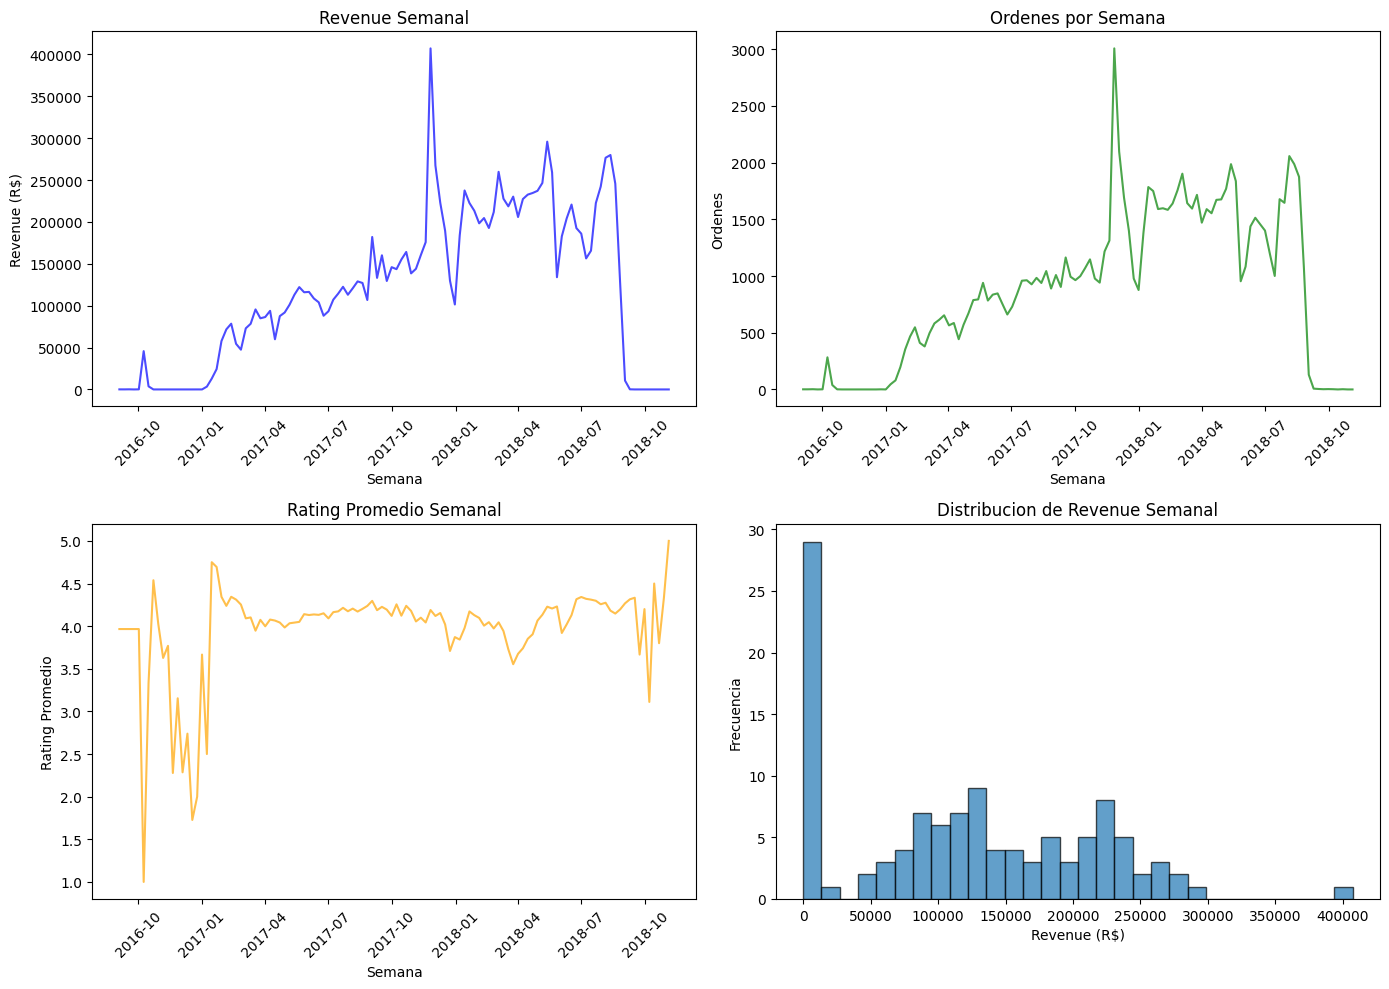

In [69]:
# Visualizar datos semanales
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Revenue semanal
axes[0, 0].plot(weekly_data['week'], weekly_data['total_revenue'], 'b-', alpha=0.7)
axes[0, 0].set_title('Revenue Semanal')
axes[0, 0].set_xlabel('Semana')
axes[0, 0].set_ylabel('Revenue (R$)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Order count semanal
axes[0, 1].plot(weekly_data['week'], weekly_data['order_count'], 'g-', alpha=0.7)
axes[0, 1].set_title('Ordenes por Semana')
axes[0, 1].set_xlabel('Semana')
axes[0, 1].set_ylabel('Ordenes')
axes[0, 1].tick_params(axis='x', rotation=45)

# Avg review score semanal
axes[1, 0].plot(weekly_data['week'], weekly_data['avg_review_score'], 'orange', alpha=0.7)
axes[1, 0].set_title('Rating Promedio Semanal')
axes[1, 0].set_xlabel('Semana')
axes[1, 0].set_ylabel('Rating Promedio')
axes[1, 0].tick_params(axis='x', rotation=45)

# Distribucion de revenue
axes[1, 1].hist(weekly_data['total_revenue'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribucion de Revenue Semanal')
axes[1, 1].set_xlabel('Revenue (R$)')
axes[1, 1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [77]:
weekly_data.tail(20)

,week,order_count,total_revenue,total_items,review_count,avg_review_score,std_review_score
94,2018-06-24,1457.0,192587.99,1651.0,1635.0,4.315596,1.159589
95,2018-07-01,1401.0,185984.37,1622.0,1491.0,4.342052,1.123141
96,2018-07-08,1196.0,156419.80,1345.0,1514.0,4.320343,1.170138
97,2018-07-15,1001.0,165640.58,1099.0,1460.0,4.310959,1.178056
98,2018-07-22,1678.0,222527.28,1873.0,460.0,4.297826,1.173600
99,2018-07-29,1646.0,242163.15,1900.0,1682.0,4.256837,1.239122
100,2018-08-05,2058.0,276573.90,2305.0,1872.0,4.274573,1.232221
101,2018-08-12,1988.0,279889.59,2254.0,1831.0,4.181868,1.300365
102,2018-08-19,1875.0,245609.63,2054.0,2046.0,4.147605,1.319299
103,2018-08-26,1071.0,126434.29,1192.0,1987.0,4.196779,1.266196


In [ ]:
print(df_weekly.tail(5))

# Muestra si hay filas con reviews pero revenue 0
extraños = df_weekly[ (df_weekly['order_count'] == 0) & (df_weekly['avg_review_score'].notnull()) ]
print(f"Semanas extrañas (Review sí, Venta no): {len(extraños)}")

## 3. Feature Engineering

Creamos features temporales para capturar patrones:
- **Lags semanales**: `revenue_lag_1`, `revenue_lag_2`, `revenue_lag_4` (valores pasados)
- **Medias moviles**: `revenue_roll_4` (tendencia de 4 semanas = 1 mes)
- **Calendario**: `week_of_year` (1-52) para capturar estacionalidad

In [70]:
df = weekly_data.copy()
df = df.sort_values('week').reset_index(drop=True)

# Lags de revenue
df['revenue_lag_1'] = df['total_revenue'].shift(1)
df['revenue_lag_2'] = df['total_revenue'].shift(2)
df['revenue_lag_4'] = df['total_revenue'].shift(4)

# Lags de orders
df['orders_lag_1'] = df['order_count'].shift(1)

# Media movil de 4 semanas (tendencia mensual)
df['revenue_roll_4'] = df['total_revenue'].rolling(window=4, min_periods=1).mean()

# Features de calendario
df['week_of_year'] = df['week'].dt.isocalendar().week.astype(int)
df['month'] = df['week'].dt.month

print(f"Dataset con features: {len(df)} semanas, {len(df.columns)} columnas")
print(f"\nFeatures creadas:")
print([c for c in df.columns if c not in weekly_data.columns])

Dataset con features: 114 semanas, 14 columnas

Features creadas:
['revenue_lag_1', 'revenue_lag_2', 'revenue_lag_4', 'orders_lag_1', 'revenue_roll_4', 'week_of_year', 'month']


In [71]:
# Eliminar filas con NaN por lag (primeras 4 semanas)
df_clean = df.dropna(subset=['revenue_lag_1', 'revenue_lag_2', 'revenue_lag_4']).copy()

print(f"Dataset limpio: {len(df_clean)} semanas (perdimos {len(df) - len(df_clean)} por lags)")
df_clean.head()

Dataset limpio: 110 semanas (perdimos 4 por lags)


,week,order_count,total_revenue,total_items,review_count,avg_review_score,std_review_score,revenue_lag_1,revenue_lag_2,revenue_lag_4,orders_lag_1,revenue_roll_4,week_of_year,month
4,2016-10-02,1.0,100.00,1.0,0.0,3.965934,1.368726,0.00,134.97,72.89,0.0,73.6175,39,10
5,2016-10-09,283.0,45715.09,322.0,1.0,1.000000,1.368726,100.00,0.00,59.50,1.0,11487.5150,40,10
6,2016-10-16,39.0,3692.57,40.0,3.0,3.333333,2.081666,45715.09,100.00,134.97,283.0,12376.9150,41,10
7,2016-10-23,1.0,0.00,0.0,52.0,4.538462,0.959198,3692.57,45715.09,0.00,39.0,12376.9150,42,10
8,2016-10-30,0.0,0.00,0.0,77.0,4.025974,1.450717,0.00,3692.57,100.00,1.0,12351.9150,43,10


## 4. Analisis de Correlacion Mejorado

### 4.1 Correlacion de Pearson con datos semanales
### 4.2 Correlacion Cruzada (Cross-Correlation)

Pregunta clave: **Mejorar el sentimiento HOY impacta las ventas de la PROXIMA SEMANA?**

In [72]:
# Funcion de correlacion con p-value
def calc_correlation_with_pvalue(x, y):
    """Calcula correlacion de Pearson con p-value."""
    mask = ~(np.isnan(x) | np.isnan(y))
    if mask.sum() < 3:
        return np.nan, np.nan
    return stats.pearsonr(x[mask], y[mask])

# Correlaciones basicas (semana t)
print("="*60)
print("CORRELACIONES BASICAS (Semana t)")
print("="*60)

basic_pairs = [
    ('avg_review_score', 'total_revenue'),
    ('avg_review_score', 'order_count'),
    ('review_count', 'total_revenue'),
    ('review_count', 'order_count'),
]

correlations = {}
print(f"\nCorrelaciones Reviews-Ventas (n={len(df_clean)} semanas):")
for col1, col2 in basic_pairs:
    corr, pval = calc_correlation_with_pvalue(df_clean[col1].values, df_clean[col2].values)
    correlations[f'{col1}_vs_{col2}'] = {'r': corr, 'p': pval}
    sig = "*" if pval < 0.05 else ""
    print(f"  {col1} vs {col2}: r={corr:.3f}, p={pval:.4f} {sig}")

print("\n* = estadisticamente significativo (p < 0.05)")

CORRELACIONES BASICAS (Semana t)

Correlaciones Reviews-Ventas (n=110 semanas):
  avg_review_score vs total_revenue: r=0.284, p=0.0027 *
  avg_review_score vs order_count: r=0.286, p=0.0025 *
  review_count vs total_revenue: r=0.839, p=0.0000 *
  review_count vs order_count: r=0.843, p=0.0000 *

* = estadisticamente significativo (p < 0.05)


In [73]:
# Cross-Correlation: Reviews en semana t vs Ventas en semana t+1 y t+2
print("="*60)
print("CROSS-CORRELATION: El sentimiento HOY afecta ventas FUTURAS?")
print("="*60)

# Crear columnas de ventas futuras
df_clean['revenue_t1'] = df_clean['total_revenue'].shift(-1)  # semana siguiente
df_clean['revenue_t2'] = df_clean['total_revenue'].shift(-2)  # dos semanas despues

cross_correlations = {}

print("\nCorrelacion: avg_review_score(t) vs total_revenue(t+lag)")
for lag, col in [(0, 'total_revenue'), (1, 'revenue_t1'), (2, 'revenue_t2')]:
    corr, pval = calc_correlation_with_pvalue(
        df_clean['avg_review_score'].values, 
        df_clean[col].values
    )
    cross_correlations[f'review_score_t_vs_revenue_t{lag}'] = {'r': corr, 'p': pval, 'lag': lag}
    sig = "*" if pval < 0.05 else ""
    print(f"  Lag {lag} semana(s): r={corr:.3f}, p={pval:.4f} {sig}")

print("\nCorrelacion: review_count(t) vs total_revenue(t+lag)")
for lag, col in [(0, 'total_revenue'), (1, 'revenue_t1'), (2, 'revenue_t2')]:
    corr, pval = calc_correlation_with_pvalue(
        df_clean['review_count'].values, 
        df_clean[col].values
    )
    cross_correlations[f'review_count_t_vs_revenue_t{lag}'] = {'r': corr, 'p': pval, 'lag': lag}
    sig = "*" if pval < 0.05 else ""
    print(f"  Lag {lag} semana(s): r={corr:.3f}, p={pval:.4f} {sig}")

CROSS-CORRELATION: El sentimiento HOY afecta ventas FUTURAS?

Correlacion: avg_review_score(t) vs total_revenue(t+lag)
  Lag 0 semana(s): r=0.284, p=0.0027 *
  Lag 1 semana(s): r=0.325, p=0.0006 *
  Lag 2 semana(s): r=0.328, p=0.0005 *

Correlacion: review_count(t) vs total_revenue(t+lag)
  Lag 0 semana(s): r=0.839, p=0.0000 *
  Lag 1 semana(s): r=0.754, p=0.0000 *
  Lag 2 semana(s): r=0.693, p=0.0000 *


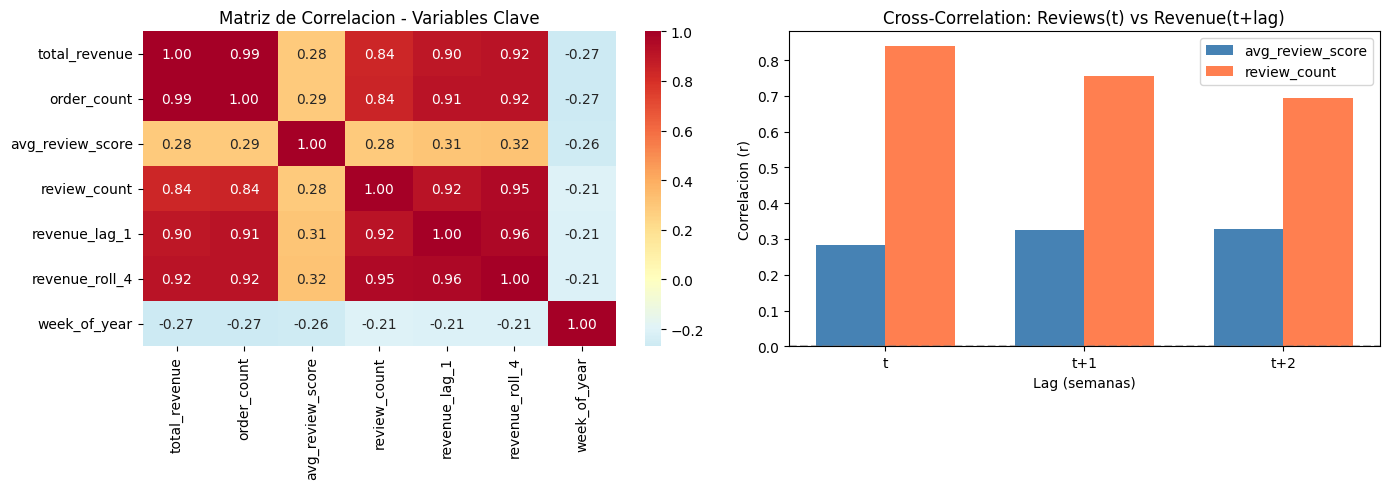

In [74]:
# Heatmap de correlaciones cruzadas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de correlacion para variables clave
corr_cols = ['total_revenue', 'order_count', 'avg_review_score', 'review_count', 
             'revenue_lag_1', 'revenue_roll_4', 'week_of_year']
corr_matrix = df_clean[corr_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f', ax=axes[0])
axes[0].set_title('Matriz de Correlacion - Variables Clave')

# Cross-correlation visual
lags = [0, 1, 2]
review_score_corrs = [cross_correlations[f'review_score_t_vs_revenue_t{l}']['r'] for l in lags]
review_count_corrs = [cross_correlations[f'review_count_t_vs_revenue_t{l}']['r'] for l in lags]

x = np.arange(len(lags))
width = 0.35

bars1 = axes[1].bar(x - width/2, review_score_corrs, width, label='avg_review_score', color='steelblue')
bars2 = axes[1].bar(x + width/2, review_count_corrs, width, label='review_count', color='coral')

axes[1].set_xlabel('Lag (semanas)')
axes[1].set_ylabel('Correlacion (r)')
axes[1].set_title('Cross-Correlation: Reviews(t) vs Revenue(t+lag)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['t', 't+1', 't+2'])
axes[1].legend()
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [75]:
# Resumen de hallazgos de correlacion
print("="*60)
print("RESUMEN DE CORRELACION CRUZADA")
print("="*60)

print("\n HALLAZGOS:")
print(f"  - Correlacion review_score(t) vs revenue(t): {cross_correlations['review_score_t_vs_revenue_t0']['r']:.3f}")
print(f"  - Correlacion review_score(t) vs revenue(t+1): {cross_correlations['review_score_t_vs_revenue_t1']['r']:.3f}")
print(f"  - Correlacion review_score(t) vs revenue(t+2): {cross_correlations['review_score_t_vs_revenue_t2']['r']:.3f}")

# Interpretacion
best_lag = max(cross_correlations.items(), key=lambda x: abs(x[1]['r']) if not np.isnan(x[1]['r']) else 0)
print(f"\n Correlacion mas fuerte: {best_lag[0]} (r={best_lag[1]['r']:.3f})")

if cross_correlations['review_score_t_vs_revenue_t1']['p'] < 0.05:
    print("\n El sentimiento de las reviews ESTA SEMANA tiene correlacion significativa")
    print("   con las ventas de la PROXIMA SEMANA.")
else:
    print("\n La correlacion cruzada NO es estadisticamente significativa.")
    print("   El sentimiento no parece ser un predictor fuerte de ventas futuras.")

RESUMEN DE CORRELACION CRUZADA

 HALLAZGOS:
  - Correlacion review_score(t) vs revenue(t): 0.284
  - Correlacion review_score(t) vs revenue(t+1): 0.325
  - Correlacion review_score(t) vs revenue(t+2): 0.328

 Correlacion mas fuerte: review_count_t_vs_revenue_t0 (r=0.839)

 El sentimiento de las reviews ESTA SEMANA tiene correlacion significativa
   con las ventas de la PROXIMA SEMANA.


## 5. Modelado con Separacion Temporal Estricta

- **Train**: Primeras 80% semanas (cronologicamente)
- **Test**: Ultimas 20% semanas (futuro)
- **Modelos**: Ridge Regression (regularizado) y RandomForest (con max_depth=5 para evitar overfitting)

In [18]:
# Preparar features y target
features = ['revenue_lag_1', 'revenue_lag_2', 'revenue_lag_4', 'orders_lag_1', 
            'revenue_roll_4', 'avg_review_score', 'week_of_year']
target = 'total_revenue'

# Eliminar columnas temporales de cross-correlation
df_model = df_clean.drop(columns=['revenue_t1', 'revenue_t2'], errors='ignore').copy()

X = df_model[features]
y = df_model[target]

print(f"Features: {features}")
print(f"Target: {target}")
print(f"\nDatos: {len(X)} semanas")

Features: ['revenue_lag_1', 'revenue_lag_2', 'revenue_lag_4', 'orders_lag_1', 'revenue_roll_4', 'avg_review_score', 'week_of_year']
Target: total_revenue

Datos: 110 semanas


In [19]:
# Split temporal estricto (80% train, 20% test)
split_idx = int(len(X) * 0.80)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Fechas de split
train_end = df_model.iloc[split_idx-1]['week']
test_start = df_model.iloc[split_idx]['week']

print(f"Train: {len(X_train)} semanas (hasta {train_end.strftime('%Y-%m-%d')})")
print(f"Test: {len(X_test)} semanas (desde {test_start.strftime('%Y-%m-%d')})")

Train: 88 semanas (hasta 2018-06-03)
Test: 22 semanas (desde 2018-06-10)


In [20]:
# Escalar features para modelos lineales
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features escaladas para Ridge/Lasso")

Features escaladas para Ridge/Lasso


In [21]:
# Entrenar modelos
models = {
    'Ridge (alpha=1.0)': Ridge(alpha=1.0),
    'Ridge (alpha=10.0)': Ridge(alpha=10.0),
    'Lasso (alpha=1.0)': Lasso(alpha=1.0),
    'RandomForest (depth=5)': RandomForestRegressor(n_estimators=100, max_depth=5, 
                                                     min_samples_leaf=3, random_state=42),
}

results = []

for name, model in models.items():
    # Usar datos escalados para modelos lineales, originales para RF
    if 'Forest' in name:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    
    # Metricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })
    print(f"{name}: MAE=R${mae:,.0f}, RMSE=R${rmse:,.0f}, R2={r2:.3f}")

results_df = pd.DataFrame(results).sort_values('MAE')
print("\n" + "="*50)
results_df

Ridge (alpha=1.0): MAE=R$23,777, RMSE=R$36,337, R2=0.889
Ridge (alpha=10.0): MAE=R$33,499, RMSE=R$48,641, R2=0.802
Lasso (alpha=1.0): MAE=R$20,569, RMSE=R$30,615, R2=0.921


RandomForest (depth=5): MAE=R$31,887, RMSE=R$47,816, R2=0.808


,Model,MAE,RMSE,R2
2,Lasso (alpha=1.0),20568.932133,30615.223490,0.921471
0,Ridge (alpha=1.0),23777.239342,36336.721982,0.889376
3,RandomForest (depth=5),31887.204294,47815.857655,0.808442
1,Ridge (alpha=10.0),33499.057122,48640.863254,0.801774


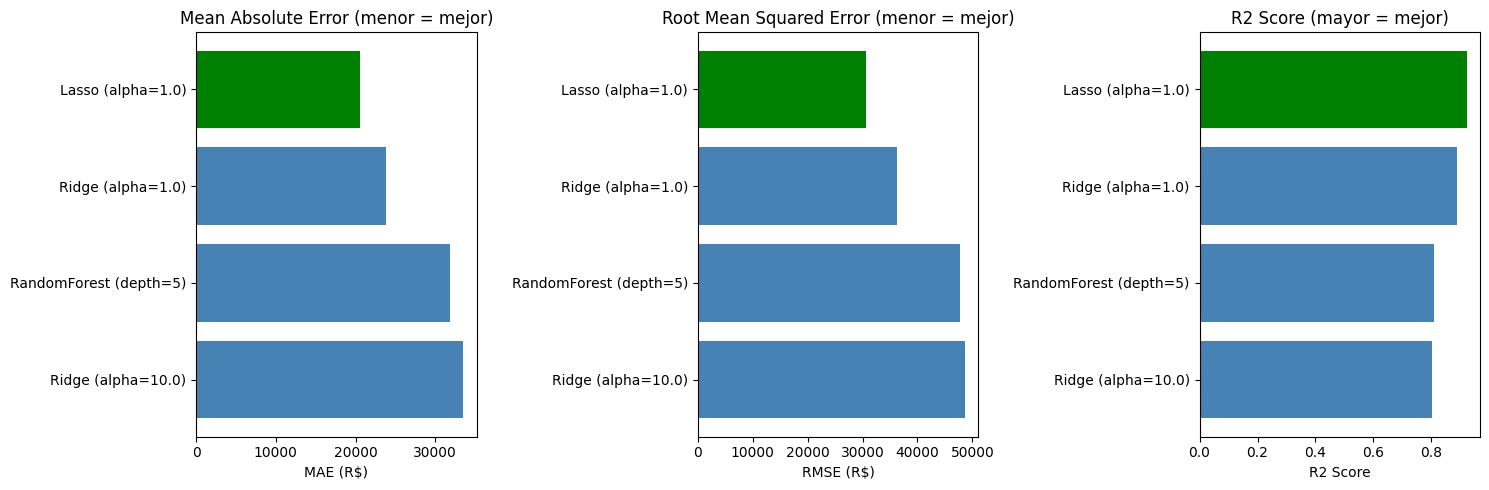

In [22]:
# Visualizar comparacion de modelos
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MAE
colors = ['green' if i == 0 else 'steelblue' for i in range(len(results_df))]
axes[0].barh(results_df['Model'], results_df['MAE'], color=colors)
axes[0].set_xlabel('MAE (R$)')
axes[0].set_title('Mean Absolute Error (menor = mejor)')
axes[0].invert_yaxis()

# RMSE
axes[1].barh(results_df['Model'], results_df['RMSE'], color=colors)
axes[1].set_xlabel('RMSE (R$)')
axes[1].set_title('Root Mean Squared Error (menor = mejor)')
axes[1].invert_yaxis()

# R2
results_sorted_r2 = results_df.sort_values('R2', ascending=False)
colors_r2 = ['green' if i == 0 else 'steelblue' for i in range(len(results_sorted_r2))]
axes[2].barh(results_sorted_r2['Model'], results_sorted_r2['R2'], color=colors_r2)
axes[2].set_xlabel('R2 Score')
axes[2].set_title('R2 Score (mayor = mejor)')
axes[2].invert_yaxis()
axes[2].axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [23]:
# Seleccionar mejor modelo (mejor R2)
best_row = results_df.sort_values('R2', ascending=False).iloc[0]
best_model_name = best_row['Model']
best_metrics = best_row

print(f"Mejor modelo: {best_model_name}")
print(f"  MAE: R${best_metrics['MAE']:,.0f}")
print(f"  RMSE: R${best_metrics['RMSE']:,.0f}")
print(f"  R2: {best_metrics['R2']:.3f}")

Mejor modelo: Lasso (alpha=1.0)
  MAE: R$20,569
  RMSE: R$30,615
  R2: 0.921


In [24]:
# Re-entrenar mejor modelo con TODOS los datos
if 'Forest' in best_model_name:
    best_model = RandomForestRegressor(n_estimators=100, max_depth=5, 
                                        min_samples_leaf=3, random_state=42)
    best_model.fit(X, y)
    y_pred_all = best_model.predict(X)
    model_type = 'rf'
elif 'Lasso' in best_model_name:
    best_model = Lasso(alpha=1.0)
    X_all_scaled = scaler.fit_transform(X)
    best_model.fit(X_all_scaled, y)
    y_pred_all = best_model.predict(X_all_scaled)
    model_type = 'lasso'
else:
    alpha = 10.0 if 'alpha=10' in best_model_name else 1.0
    best_model = Ridge(alpha=alpha)
    X_all_scaled = scaler.fit_transform(X)
    best_model.fit(X_all_scaled, y)
    y_pred_all = best_model.predict(X_all_scaled)
    model_type = 'ridge'

print(f"Modelo {best_model_name} re-entrenado con {len(X)} semanas")

Modelo Lasso (alpha=1.0) re-entrenado con 110 semanas


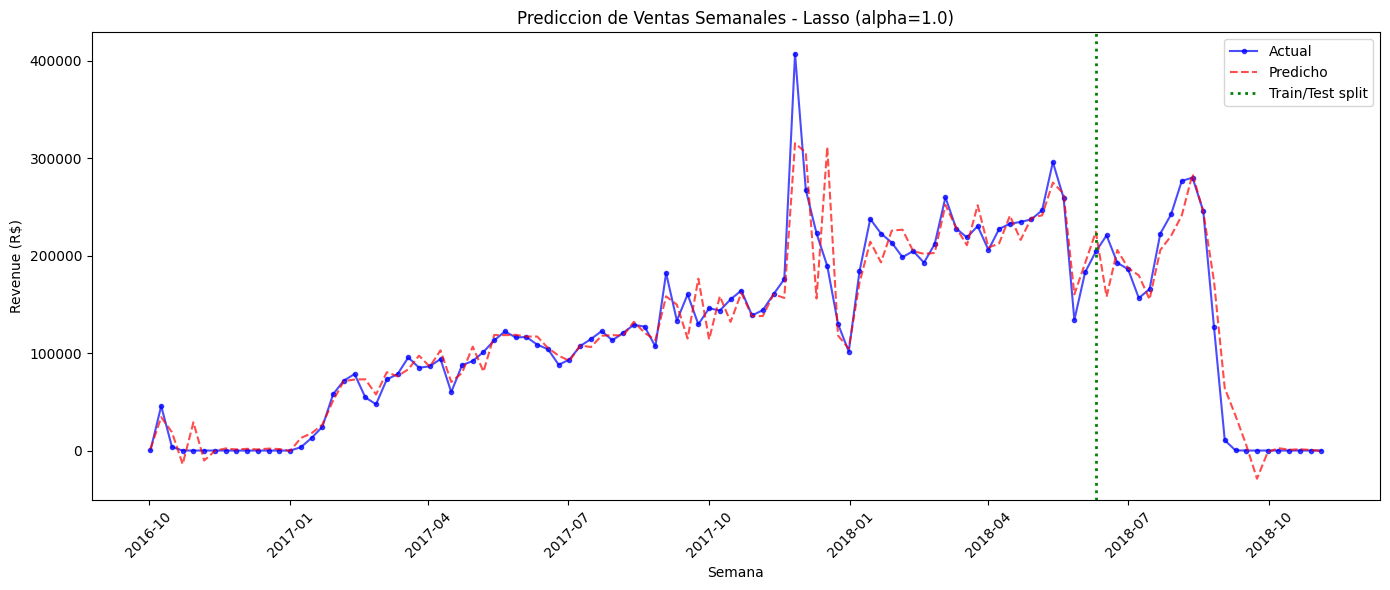

In [25]:
# Visualizar predicciones vs actual
plt.figure(figsize=(14, 6))
plt.plot(df_model['week'], y, 'b-', label='Actual', marker='o', markersize=3, alpha=0.7)
plt.plot(df_model['week'], y_pred_all, 'r--', label='Predicho', alpha=0.7)
plt.axvline(x=df_model['week'].iloc[split_idx], color='green', linestyle=':', 
            linewidth=2, label='Train/Test split')

plt.xlabel('Semana')
plt.ylabel('Revenue (R$)')
plt.title(f'Prediccion de Ventas Semanales - {best_model_name}')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
# Feature importance (si es RF)
if model_type == 'rf':
    importances = pd.DataFrame({
        'feature': features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importances['feature'], importances['importance'], color='steelblue')
    plt.xlabel('Importancia')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    print("\nTop features:")
    print(importances.sort_values('importance', ascending=False).head())
else:
    print("\nCoeficientes del modelo:")
    coefs = pd.DataFrame({
        'feature': features,
        'coef': best_model.coef_
    }).sort_values('coef', key=abs, ascending=False)
    print(coefs)


Coeficientes del modelo:
            feature           coef
4    revenue_roll_4  218850.970448
1     revenue_lag_2  -89868.586584
0     revenue_lag_1  -36649.511975
2     revenue_lag_4  -27196.933894
3      orders_lag_1    8562.601598
6      week_of_year   -2915.637911
5  avg_review_score    -616.253710


## 6. Guardar Modelo y Artefactos

In [27]:
# Crear directorio de modelos
prediction_dir = project_root / "models" / "prediction"
prediction_dir.mkdir(parents=True, exist_ok=True)

# Guardar modelo
model_path = prediction_dir / "sales_predictor.joblib"
joblib.dump(best_model, model_path)
print(f"Modelo guardado: {model_path}")

# Guardar scaler (si se uso)
if model_type in ['ridge', 'lasso']:
    scaler_path = prediction_dir / "sales_scaler.joblib"
    joblib.dump(scaler, scaler_path)
    print(f"Scaler guardado: {scaler_path}")

Modelo guardado: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\models\prediction\sales_predictor.joblib
Scaler guardado: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\models\prediction\sales_scaler.joblib


In [28]:
# Guardar metadata del modelo
metadata = {
    "model_type": best_model_name,
    "model_class": model_type,
    "features": features,
    "target": target,
    "granularity": "weekly",
    "metrics": {
        "mae": float(best_metrics['MAE']),
        "rmse": float(best_metrics['RMSE']),
        "r2": float(best_metrics['R2']),
    },
    "training_samples": len(X),
    "train_test_split": 0.80,
    "date_range": {
        "start": str(df_model['week'].min()),
        "end": str(df_model['week'].max())
    }
}

with open(prediction_dir / "model_metadata.json", 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Metadata guardada: {prediction_dir / 'model_metadata.json'}")

Metadata guardada: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\models\prediction\model_metadata.json


In [29]:
# Guardar correlaciones para el agente
all_correlations = {
    "basic_correlations": {k: {"r": float(v['r']) if not np.isnan(v['r']) else None, 
                                "p": float(v['p']) if not np.isnan(v['p']) else None} 
                           for k, v in correlations.items()},
    "cross_correlations": {k: {"r": float(v['r']) if not np.isnan(v['r']) else None,
                                "p": float(v['p']) if not np.isnan(v['p']) else None,
                                "lag": v['lag']} 
                           for k, v in cross_correlations.items()},
    "n_samples": len(df_clean),
    "granularity": "weekly"
}

with open(prediction_dir / "correlation_results.json", 'w') as f:
    json.dump(all_correlations, f, indent=2)
print(f"Correlaciones guardadas: {prediction_dir / 'correlation_results.json'}")

Correlaciones guardadas: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\models\prediction\correlation_results.json


In [30]:
# Guardar ultimas 4 semanas de datos CON VENTAS REALES para predicciones futuras del agente
# Filtramos semanas con revenue > 0 para obtener datos significativos
df_with_sales = df_model[df_model['total_revenue'] > 0]
latest_data = df_with_sales.tail(4)[['week', 'total_revenue', 'order_count', 'avg_review_score', 
                                 'revenue_lag_1', 'revenue_lag_2', 'revenue_lag_4', 
                                 'orders_lag_1', 'revenue_roll_4', 'week_of_year']].copy()
latest_data['week'] = latest_data['week'].astype(str)

# Guardar en silver para acceso del agente
silver_path = settings.silver_dir / "latest_sales_data.json"
latest_data.to_json(silver_path, orient='records', indent=2)
print(f"Datos recientes guardados: {silver_path}")

print("\nUltimas 4 semanas CON VENTAS:")
latest_data

Datos recientes guardados: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\data\silver\latest_sales_data.json

Ultimas 4 semanas CON VENTAS:


,week,total_revenue,order_count,avg_review_score,revenue_lag_1,revenue_lag_2,revenue_lag_4,orders_lag_1,revenue_roll_4,week_of_year
102,2018-08-19,245609.63,1875.0,4.147605,279889.59,276573.90,222527.28,1988.0,261059.0675,33
103,2018-08-26,126434.29,1071.0,4.196779,245609.63,279889.59,242163.15,1875.0,232126.8525,34
104,2018-09-02,10565.86,130.0,4.267479,126434.29,245609.63,276573.90,1071.0,165624.8425,35
105,2018-09-09,145.00,7.0,4.314815,10565.86,126434.29,279889.59,130.0,95688.6950,36


## 7. Resumen Final

In [ ]:
print("="*70)
print("RESUMEN DEL ANALISIS Y MODELADO")
print("="*70)

print(f"\n DATOS")
print(f"  - Granularidad: SEMANAL (vs mensual anterior)")
print(f"  - Semanas totales: {len(df_model)}")
print(f"  - Rango: {df_model['week'].min().strftime('%Y-%m-%d')} a {df_model['week'].max().strftime('%Y-%m-%d')}")

print(f"\n CORRELACIONES")
print(f"  - review_score vs revenue: r={correlations['avg_review_score_vs_total_revenue']['r']:.3f}")
print(f"  - review_count vs revenue: r={correlations['review_count_vs_total_revenue']['r']:.3f}")
print(f"\n  Cross-correlation (sentimiento hoy -> ventas manana?):")
print(f"    - Lag 0: r={cross_correlations['review_score_t_vs_revenue_t0']['r']:.3f}")
print(f"    - Lag 1: r={cross_correlations['review_score_t_vs_revenue_t1']['r']:.3f}")
print(f"    - Lag 2: r={cross_correlations['review_score_t_vs_revenue_t2']['r']:.3f}")

print(f"\n MODELO")
print(f"  - Mejor modelo: {best_model_name}")
print(f"  - Features: {features}")
print(f"  - MAE: R${best_metrics['MAE']:,.0f}")
print(f"  - RMSE: R${best_metrics['RMSE']:,.0f}")
print(f"  - R2: {best_metrics['R2']:.3f}")

print(f"\n ARTEFACTOS GUARDADOS")
print(f"  - Modelo: {prediction_dir / 'sales_predictor.joblib'}")
print(f"  - Metadata: {prediction_dir / 'model_metadata.json'}")
print(f"  - Correlaciones: {prediction_dir / 'correlation_results.json'}")
print(f"  - Datos recientes: {silver_path}")

print("\n" + "="*70)

RESUMEN DEL ANALISIS Y MODELADO

📊 DATOS
  - Granularidad: SEMANAL (vs mensual anterior)
  - Semanas totales: 110
  - Rango: 2016-10-02 a 2018-11-04

🔗 CORRELACIONES
  - review_score vs revenue: r=0.284
  - review_count vs revenue: r=0.839

  Cross-correlation (sentimiento hoy -> ventas manana?):
    - Lag 0: r=0.284
    - Lag 1: r=0.325
    - Lag 2: r=0.328

🤖 MODELO
  - Mejor modelo: Lasso (alpha=1.0)
  - Features: ['revenue_lag_1', 'revenue_lag_2', 'revenue_lag_4', 'orders_lag_1', 'revenue_roll_4', 'avg_review_score', 'week_of_year']
  - MAE: R$20,569
  - RMSE: R$30,615
  - R2: 0.921

📁 ARTEFACTOS GUARDADOS
  - Modelo: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\models\prediction\sales_predictor.joblib
  - Metadata: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\models\prediction\model_metadata.json
  - Correlaciones: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVIT

In [ ]:
# Interpretacion para el agente
print("\n INTERPRETACION PARA EL AGENTE:")
print("-" * 50)

if best_metrics['R2'] > 0.5:
    print("El modelo tiene capacidad predictiva aceptable (R2 > 0.5)")
elif best_metrics['R2'] > 0:
    print("El modelo tiene capacidad predictiva limitada (0 < R2 < 0.5)")
    print("   Las predicciones deben tomarse con cautela.")
else:
    print("El modelo tiene capacidad predictiva muy baja (R2 < 0)")
    print("   Se recomienda usar promedios historicos en lugar de predicciones.")

print(f"\n El modelo puede predecir ventas semanales con un error promedio")
print(f"   de R${best_metrics['MAE']:,.0f} (MAE)")

# Calcular error como % del promedio
avg_revenue = y.mean()
error_pct = (best_metrics['MAE'] / avg_revenue) * 100
print(f"   Esto representa ~{error_pct:.1f}% del revenue semanal promedio (R${avg_revenue:,.0f})")


📝 INTERPRETACION PARA EL AGENTE:
--------------------------------------------------
El modelo tiene capacidad predictiva aceptable (R2 > 0.5)

🎯 El modelo puede predecir ventas semanales con un error promedio
   de R$20,569 (MAE)
   Esto representa ~16.6% del revenue semanal promedio (R$123,558)
